In [1]:
import os
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
base_path = '/content/drive/MyDrive/MPI data/newww_dataset'

In [4]:
classes = {
    "Infarction": {"rest": "Infarction/rest", "stress": "Infarction/stress"},
    "Ischemia": {"rest": "Ischemia/rest", "stress": "Ischemia/stress"},
    "Normal": {"rest": "Normal/rest", "stress": "Normal/stress"}
}


In [5]:
# Function to extract Patient ID from filename
def get_patient_id(filename):
    try:
        return int(filename.split('_')[0].replace('patient', ''))
    except (ValueError, IndexError):
        return None

In [6]:
# Generate CSV files for each class
for class_name, paths in classes.items():
    csv_filename = f"{class_name}_images.csv"
    with open(csv_filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(["Patient_ID", "Image_Type", "File_Path"])
        for image_type, folder in paths.items():
            folder_path = os.path.join(base_path, folder)
            if not os.path.exists(folder_path):
                print(f"Folder {folder_path} does not exist!")
                continue
            files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg'))]
            for file in files:
                patient_id = get_patient_id(file)
                if patient_id is not None:
                    full_path = os.path.join(folder_path, file)
                    writer.writerow([patient_id, image_type, full_path])
    print(f"Created {csv_filename} successfully!")

Created Infarction_images.csv successfully!
Created Ischemia_images.csv successfully!
Created Normal_images.csv successfully!


In [7]:
# Function to load images with range [-1, 1]
def load_images(csv_file, target_size=(224, 224)):
    data = []
    labels = []
    with open(csv_file, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader)  # Skip header
        for row in reader:
            patient_id, image_type, file_path = row
            img = load_img(file_path, target_size=target_size)
            img_array = img_to_array(img) / 127.5 - 1.0  # Scale to [-1, 1]
            data.append((patient_id, image_type, img_array))
            labels.append(class_name)
    return data, labels

In [8]:
from tensorflow.keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D, Dropout
# Build ResNet50V2 model with shared weights
def build_resnet50v2_model(input_shape=(224, 224, 3)):
    # Create a single ResNet50V2 instance to share weights
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base layers

    # Rest branch
    rest_input = Input(shape=input_shape, name='rest_input')
    rest_features = base_model(rest_input)
    x1 = GlobalAveragePooling2D()(rest_features) #add this layer for better performance

    # Stress branch
    stress_input = Input(shape=input_shape, name='stress_input')
    stress_features = base_model(stress_input)
    x2 = GlobalAveragePooling2D()(stress_features)

    # Combine branches
    combined = Concatenate()([x1, x2])

    # Output layer (required to match the 3 classes)
    x = Dense(512, activation='relu')(combined)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    output = Dense(3, activation='softmax')(x)  # 3 classes: Infarction, Ischemia, Normal


  # Build model
    model = Model(inputs=[rest_input, stress_input], outputs=output)
    # Compile with custom learning rate
    learning_rate =1e-5            #0.0001 #0.00001

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
model = build_resnet50v2_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ rest_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stress_input        │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2          │ (None, 7, 7,      │ 23,564,800 │ rest_input[0][0], │
│ (Functional)        │ 2048)             │            │ stress_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50v2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50v2[1][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4096)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  2,097,664 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │        771 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,794,563 (98.40 MB)

 Trainable params: 2,229,763 (8.51 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [9]:

# Load and prepare data
data = []
labels = []
for class_name in classes:
    csv_file = f"{class_name}_images.csv"
    class_data, class_labels = load_images(csv_file)
    data.extend(class_data)
    labels.extend(class_labels)


In [10]:
# Convert data to arrays
# First, build a patient_data dictionary from the data and labels variables obtained in cell 9.
# It groups images by patient id and records both 'rest' and 'stress' images along with the label.
patient_data = {}
for ((pid, image_type, img_array), label) in zip(data, labels):
    if pid not in patient_data:
        patient_data[pid] = {'rest': None, 'stress': None, 'label': label}
    patient_data[pid][image_type] = img_array

rest_images = []
stress_images = []
y = []
class_map = {'Infarction': 0, 'Ischemia': 1, 'Normal': 2}
for pid, info in patient_data.items():
    if info['rest'] is not None and info['stress'] is not None:
        rest_images.append(info['rest'])
        stress_images.append(info['stress'])
        y.append(class_map[info['label']])

In [11]:
rest_images = np.array(rest_images)
stress_images = np.array(stress_images)
y = np.eye(3)[y]  # One-hot encoding

In [12]:
# Split data
X_rest_train, X_rest_test, X_stress_train, X_stress_test, y_train, y_test = train_test_split(
    rest_images, stress_images, y, test_size=0.2, random_state=42
)

In [13]:
X_rest_train = X_rest_train.astype('float32')
X_stress_train = X_stress_train.astype('float32')
y_train = y_train.astype('float32')


In [14]:
# Build and train the model
model = build_resnet50v2_model()
history=model.fit([X_rest_train, X_stress_train], y_train, validation_split=0.1, epochs=50, batch_size=8)

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 45s 234ms/step - accuracy: 0.3562 - loss: 1.5040 - val_accuracy: 0.7553 - val_loss: 0.6997
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.5586 - loss: 0.9961 - val_accuracy: 0.8830 - val_loss: 0.4917
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.6734 - loss: 0.7483 - val_accuracy: 0.9149 - val_loss: 0.3966
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.7691 - loss: 0.5784 - val_accuracy: 0.9255 - val_loss: 0.3363
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.7928 - loss: 0.5065 - val_accuracy: 0.9255 - val_loss: 0.3101
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.8473 - loss: 0.4006 - val_accuracy: 0.9362 - val_loss: 0.2746
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.8751 - loss: 0.3565 - val_accuracy: 0.9362 - val_loss: 0.2498
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.8592 - loss: 0.3377 - va

In [15]:
eval_loss, eval_accuracy = model.evaluate([X_rest_test, X_stress_test], y_test, batch_size=1)
print(f"Test Loss: {eval_loss:.4f}, Test Accuracy: {eval_accuracy:.4f}")


234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9771 - loss: 0.0839
Test Loss: 0.0440, Test Accuracy: 0.9872


30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 261ms/step


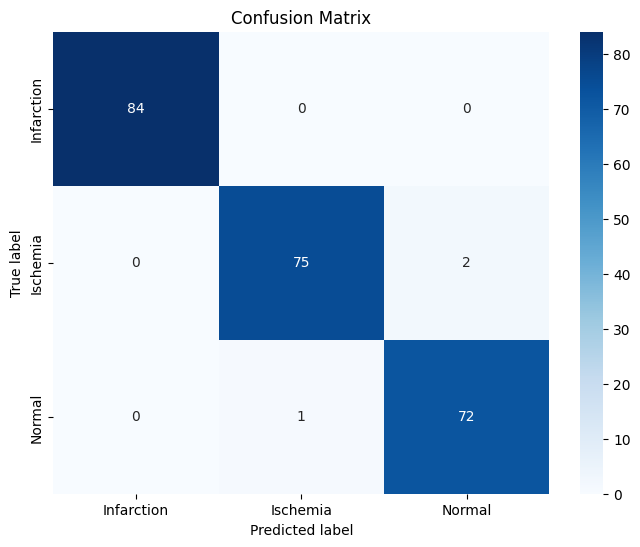

In [16]:
# Compute confusion matrix
# Remove the tf.device('/CPU:0'): block
y_pred = model.predict([X_rest_test, X_stress_test], batch_size=8)
# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Infarction', 'Ischemia', 'Normal'], yticklabels=['Infarction', 'Ischemia', 'Normal'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

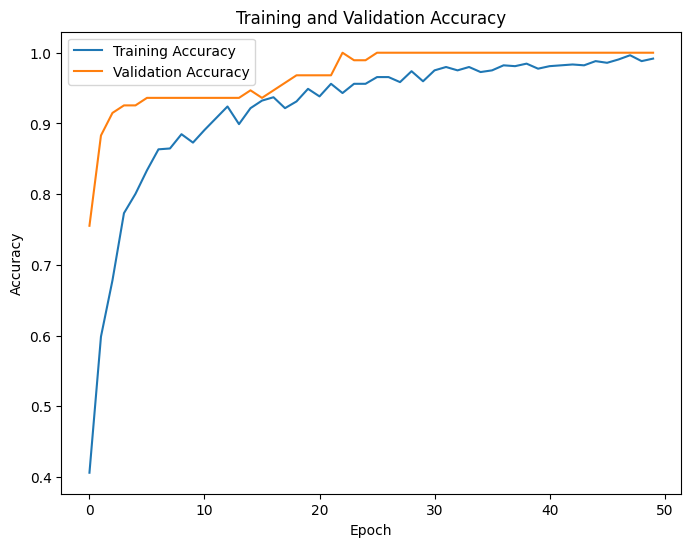

In [17]:

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

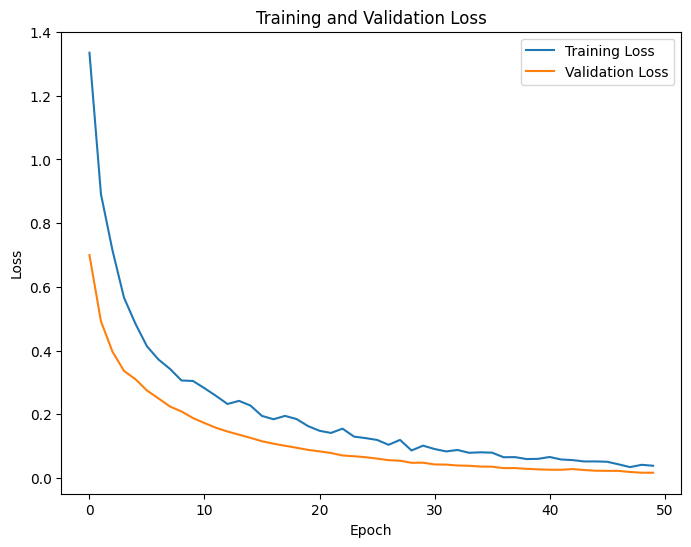

In [18]:
#print loss plot
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# prompt: print f1 and recol and preston

from sklearn.metrics import f1_score, recall_score, precision_score

# Calculate F1, Recall, and Precision
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
recol = recall_score(y_test_classes, y_pred_classes, average='weighted')
preston = precision_score(y_test_classes, y_pred_classes, average='weighted')

print(f"F1 Score: {f1:.4f}")
print(f"Recall Score: {recol:.4f}")
print(f"Precision Score: {preston:.4f}")


F1 Score: 0.9872
Recall Score: 0.9872
Precision Score: 0.9872
